In [31]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
from os.path import exists
import cv2

from tensorflow.keras import layers, Model
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import ast
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks


from tensorflow.image import resize
from tensorflow.keras import utils

In [ ]:
#Making directory in collab and moving data from drive to collab

In [16]:
mkdir /content/data

In [17]:
!cp -r /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/input_image_train /content/data
!cp -r /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/input_image_val /content/data
!cp -r /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/input_image_test /content/data
!cp -r /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/output_mask_train /content/data
!cp -r /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/output_mask_test /content/data
!cp -r /content/drive/MyDrive/oil-tanker-project/data/case1_tanks/output_mask_val /content/data

In [11]:
## Data Loader

In [13]:
# Required for Google collab
os.chdir('/content/drive/MyDrive/oil-tanker-project/notebooks')

In [118]:
class CustomGen(keras.utils.Sequence):

    def __init__(self, img_path, img_path_mask, batch_size):
        self.img_path = img_path
        self.img_path_mask = img_path_mask
        self.batch_size = batch_size
        self.list_elements = os.listdir(self.img_path)
        self.list_elements_mask = os.listdir(self.img_path_mask)

    def __len__(self):
#         self.list_elements = os.listdir(self.img_path)
#         self.list_elements_mask = os.listdir(self.img_path_mask)
        return len(self.list_elements) // self.batch_size

    def __getitem__(self,idx):        
        X_paths = self.list_elements[idx * self.batch_size:(idx+1) * self.batch_size]
        y_paths = self.list_elements_mask[idx * self.batch_size:(idx+1) * self.batch_size]

        X = []
        y = []

        for x_filename in X_paths:
            img = np.array(utils.load_img(self.img_path + x_filename,
                                 grayscale=False,
                                 color_mode='rgb',
                                 target_size=(256,256),
                                 interpolation='nearest'))


            X.append(img)
            y_filename = x_filename.replace('.jpg','_mask.jpg')
            y_path = self.img_path_mask + y_filename
            file_exists = exists(y_path)
            if file_exists:
                # y.append(load_img('../data/Oil Tanks/image_patches/'+x_filename))
                black_img = np.array(utils.load_img(y_path,
                                 grayscale=False,
                                 color_mode='rgb',
                                 target_size=(256,256),
                                 interpolation='nearest'))
                image_black_resized = black_img[:, :, 0:1]

                
            else:
#                 import ipdb; ipdb.set_trace()
                image_black_resized = (img*0)[:, :, 0:1]

            

            y.append(image_black_resized)

        return np.stack(X)/255., np.stack(y)/255.

In [119]:
!pwd

/content/data


In [120]:
os.chdir('/content/data/')

In [121]:
img_train_path = 'input_image_train/'
mask_train_path = 'output_mask_train/'

img_val_path = 'input_image_val/'
mask_val_path = 'output_mask_val/'

img_test_path = 'input_image_test/'
mask_test_path = 'output_mask_test/'

batch_size = 8

In [122]:
data_loader_train = CustomGen(img_train_path, mask_train_path, batch_size)
data_loader_val = CustomGen(img_val_path, mask_val_path, batch_size)
data_loader_test = CustomGen(img_test_path, mask_test_path, batch_size)

In [123]:
### Test Data loader

In [124]:
X,y = data_loader_train.__getitem__(42)

In [127]:
y[0].shape

(256, 256, 1)

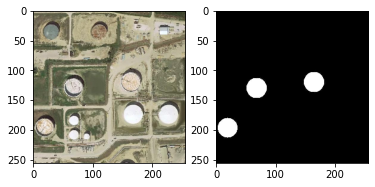

In [126]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(X[0])

plt.subplot(1,2,2)
plt.imshow(y[0].reshape(256,256), cmap ='gray')

In [ ]:
X[0].shape, y[0].shape

In [ ]:
X.shape, y.shape

In [ ]:
### UNET Function

In [30]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape = img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

In [128]:
img_size = (256,256)
num_classes = 1

In [129]:
# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [130]:
#Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [167]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)


history = model.fit(data_loader_train,
          epochs=100,
          validation_data=data_loader_val,
          callbacks=[es],
          verbose=1)

model.save('second_model.h5')

Epoch 1/100
159/159 [==============================] - 24s 148ms/step - loss: 0.0191 - accuracy: 0.9820 - val_loss: 0.0594 - val_accuracy: 0.9763
Epoch 2/100
159/159 [==============================] - 24s 152ms/step - loss: 0.0180 - accuracy: 0.9823 - val_loss: 0.1344 - val_accuracy: 0.9689
Epoch 3/100
159/159 [==============================] - 24s 151ms/step - loss: 0.0218 - accuracy: 0.9811 - val_loss: 0.0569 - val_accuracy: 0.9777
Epoch 4/100
159/159 [==============================] - 24s 149ms/step - loss: 0.0153 - accuracy: 0.9832 - val_loss: 0.0589 - val_accuracy: 0.9779
Epoch 5/100
159/159 [==============================] - 24s 150ms/step - loss: 0.0132 - accuracy: 0.9838 - val_loss: 0.0667 - val_accuracy: 0.9780
Epoch 6/100
159/159 [==============================] - 24s 150ms/step - loss: 0.0118 - accuracy: 0.9842 - val_loss: 0.0631 - val_accuracy: 0.9778
Epoch 7/100
159/159 [==============================] - 24s 149ms/step - loss: 0.0124 - accuracy: 0.9841 - val_loss: 0.0720 -

In [132]:
history.history

{'loss': [0.2429826408624649],
 'accuracy': [0.9362084865570068],
 'val_loss': [0.3548887073993683],
 'val_accuracy': [0.947487473487854]}

In [159]:
model.evaluate(data_loader_test)

125/125 [==============================] - 7s 55ms/step - loss: 0.0285 - accuracy: 0.9912


[0.0285304207354784, 0.9912309646606445]

In [163]:
X_test,y_test = data_loader_test.__getitem__(3)

In [164]:
y_test_pred = model.predict(X_test)

1/1 [==============================] - 0s 23ms/step


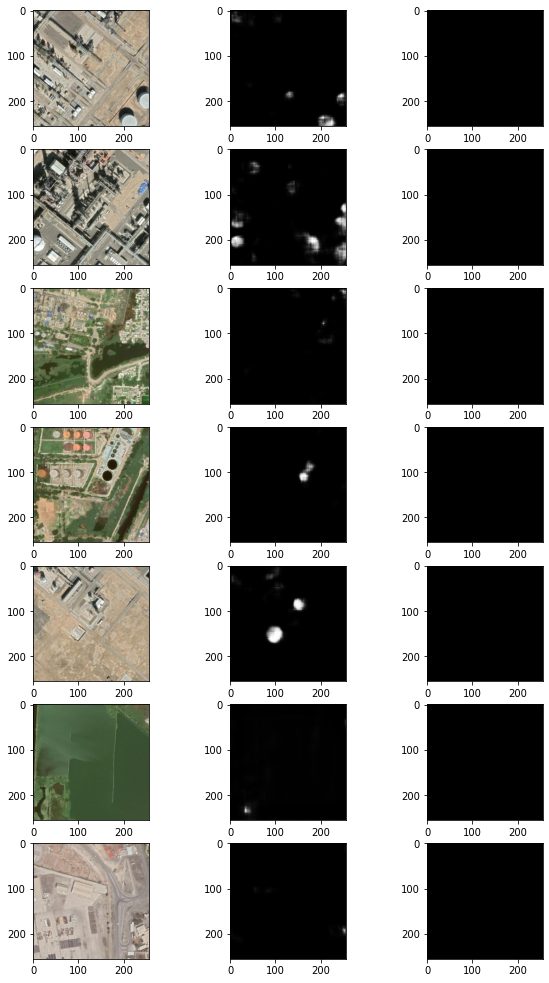

In [165]:
c=1
plt.figure(figsize=(10,20))
for i in range(1,8):
  plt.subplot(8,3,c)
  plt.imshow(X_test[i])

  plt.subplot(8,3,c+1)
  plt.imshow(y_test_pred[i].reshape(256,256), cmap ='gray')

  plt.subplot(8,3,c+2)
  plt.imshow(y_test[i].reshape(256,256), cmap ='gray')

  c+=3